# Fluid Logo

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/grids/Fluid_Logo.ipynb)


This example shows how to run a simple fluid simulation with inflows and obstacles.

In [8]:
%pip install phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.

Let's begin by defining the resolution and size of our domain, as well as the obstacle geometries.
We build a complex obstacle geometry out of multiple boxes here.

In [4]:
domain = dict(x=128, y=128, bounds=Box(x=100, y=100))
geometries = [Box(x=(15 + x * 7, 15 + (x + 1) * 7), y=(41, 83)) for x in range(1, 10, 2)] + [Box['x,y', 43:50, 41:48], Box['x,y', 15:43, 83:90], Box['x,y', 50:85, 83:90]]
geometry = union(geometries)

Let's plot the obstacle! For the right plot, we sample the geometry on a grid matching our simulation settings. The simulation will only use the sampled version. If you have thin geometries, make sure that they don't result in holes after resampling!

<Figure size 864x360 with 3 Axes>

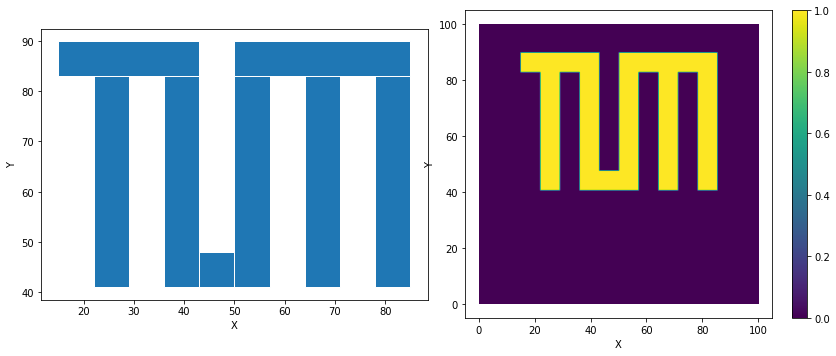

In [5]:
plot(geometry, CenteredGrid(geometry, 0, **domain))

Next, we define three smoke inflows for our simulation and sample them on a grid.

<Figure size 864x360 with 2 Axes>

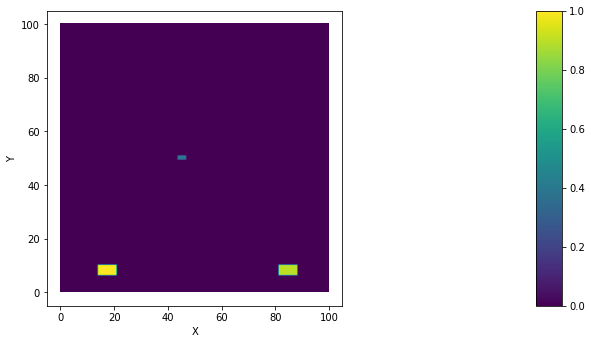

In [7]:
inflow = CenteredGrid(Box(x=(14, 21), y=(6, 10)), ZERO_GRADIENT, **domain) + \
         CenteredGrid(Box(x=(81, 88), y=(6, 10)), ZERO_GRADIENT, **domain) * 0.9 + \
         CenteredGrid(Box(x=(44, 47), y=(49, 51)), ZERO_GRADIENT, **domain) * 0.4
plot(inflow)

Finally, we define the simulation.
We let the smoke apply an upwards `buoyancy_force` on the velocity proportional to its density.
As we sample the velocity on a staggered grid but the smoke density on a centered grid, we need to resample the force to the staggered grid.
Passing the obstacle to `make_incompressible` ensures that that no fluid can flow into or out of the defined geometry.

In [12]:
@jit_compile
def step(smoke, v, pressure, inflow, dt=1.):
    smoke = advect.semi_lagrangian(smoke, v, 1) + inflow
    buoyancy_force = resample(smoke * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, 1) + buoyancy_force
    v, pressure = fluid.make_incompressible(v, geometry, Solve('CG-adaptive', 1e-5, x0=pressure))
    return smoke, v, pressure

v0 = StaggeredGrid(0, boundary=0, **domain)
smoke0 = CenteredGrid(0, boundary=ZERO_GRADIENT, **domain)
smoke_trj, v_trj, pressure_trj = iterate(step, batch(time=200), smoke0, v0, None, inflow=inflow)

Note that passing `batch(time=200)` to `iterate` stacks the variables along a new dimension called `time`.
This allows us to easily animate the result.

In [13]:
plot(smoke_trj.time[::2], animate='time')